In [8]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8
import decord
from decord import cpu, gpu
import numpy as np
import torchvision.transforms as T

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [27]:
device2 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device2

device(type='cuda', index=1)

In [20]:
def get_video(video_path, fps=30):
        # If fixed width and height are required, VideoReader takes width and height as arguments.
        video_reader = decord.VideoReader(str(video_path), num_threads=1, ctx=cpu(0))
        decord.bridge.set_bridge('torch')
        vlen = len(video_reader)
        print(vlen)
        original_fps = video_reader.get_avg_fps()
        print(original_fps)
        num_frames = int(vlen * fps / original_fps)
        # num_frames = min(self.max_num_frames, num_frames)
        frame_idxs = np.linspace(0, vlen, num_frames, endpoint=False).astype(np.int_)
        video = video_reader.get_batch(frame_idxs).byte()
        video = video.permute(0, 3, 1, 2)
        return video

In [23]:
video_id = 3489439407
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')
video.shape

1662
29.97002997002997


torch.Size([1663, 3, 480, 640])

In [25]:

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-14-SigLIP-384')
model = model.to(device)
preprocess = preprocess
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-14-SigLIP-384')

transform = T.ToPILImage()
sampling_rate = 10
images = [transform(video[i]) for i in range(0, video.shape[0], sampling_rate)]

labels_list = ["lady in blue standing listening to her headphones"]
image_stack = torch.stack([preprocess(image) for image in images]).to(device)
text = tokenizer(labels_list, context_length=model.context_length).to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_stack)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)
    print("Image features shape: ", image_features.shape, "Text features shape: ", text_features.shape)

    text_probs = torch.sigmoid(text_features @ image_features.T * model.logit_scale.exp() + model.logit_bias)

values, indices = torch.topk(text_probs, 3)

Image features shape:  torch.Size([167, 1152]) Text features shape:  torch.Size([1, 1152])


150

133/1663


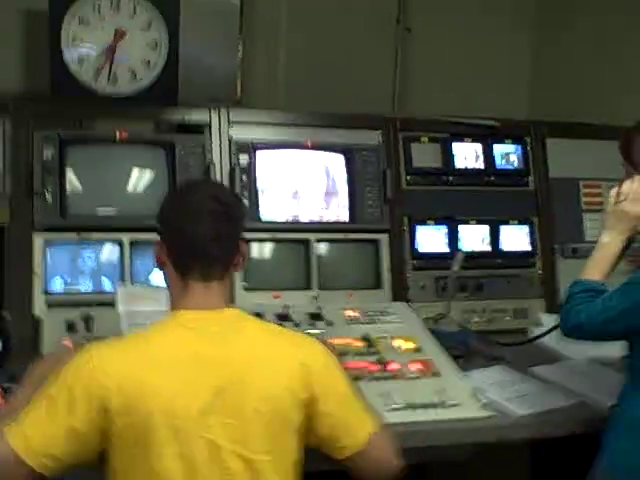

In [70]:
raw_image = images[indices[0][0].item() - 150]
print(f"{indices[0][0].item()}/{video.shape[0]}")
raw_image

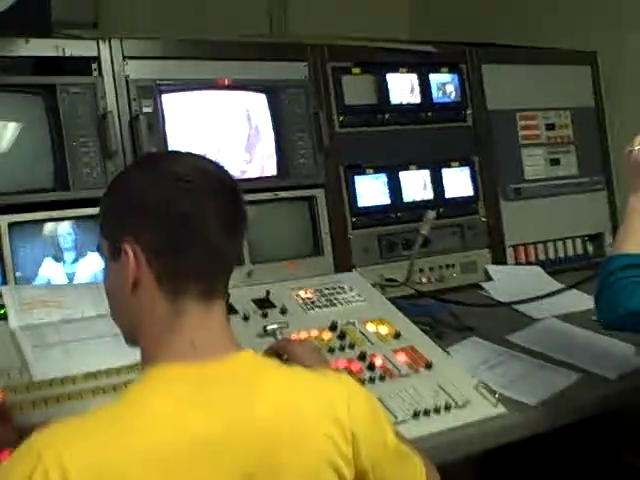

In [71]:
raw_image = images[indices[0][0].item() + 13]
raw_image

In [73]:
from lavis.models import load_model_and_preprocess
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True, device=device2)
# preprocess the image
# vis_processors stores image transforms for "train" and "eval" (validation / testing / inference)
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
# generate caption
model.generate({"image": image})
# ['a large fountain spewing water into the air']

['a man and a woman in a control room']

In [75]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa", model_type="vqav2", is_eval=True, device=device2)
# ask a random question.
question = "What is the man doing in the video?"
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device2)
question = txt_processors["eval"](question)
model.predict_answers(samples={"image": image, "text_input": question}, inference_method="generate")

['watching tv']

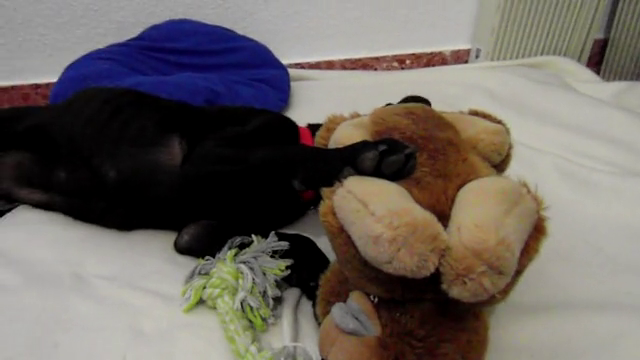